In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform, randint

#import missingno as msno
#import xgboost as xgb
#from catboost import CatBoostRegressor

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_validate, ShuffleSplit,  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV

import dtreeviz

from mapie.classification import MapieClassifier

In [2]:
data = pd.read_csv("./datasets/data.csv", index_col="EmployeeID")

In [3]:
categorical_columns = [
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "WorkLifeBalance",
    "BusinessTravel",
    "Department",
    "Education",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "JobLevel",
    "StockOptionLevel",
    "JobInvolvement",
    "PerformanceRating",
]

numerical_columns = [
    "Age",
    "DistanceFromHome",
    "MonthlyIncome",
    "NumCompaniesWorked",
    "PercentSalaryHike",
    "TotalWorkingYears",
    "TrainingTimesLastYear",
    "YearsAtCompany",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
    "DaysNotWorked",
    "AverageHoursPerday"
]

col_with_NA = ['NumCompaniesWorked', 'TotalWorkingYears'] # Use mean imputation later (numerical features with few missing values)

target_column = "Attrition"

In [4]:
target = data[target_column].map({'No': 0, 'Yes': 1})
target

EmployeeID
1       0
2       1
3       0
4       0
5       0
       ..
4406    0
4407    0
4408    0
4409    0
4410    0
Name: Attrition, Length: 4410, dtype: int64

In [5]:
data = data.drop(columns=[target_column])
data = data[numerical_columns+categorical_columns]
data.head()

,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,...,Department,Education,EducationField,Gender,JobRole,MaritalStatus,JobLevel,StockOptionLevel,JobInvolvement,PerformanceRating
EmployeeID,,,,,,,,,,,,,,,,,,,,,
1,51,6,131160,1.0,11,1.0,6,1,0,0,...,Sales,2,Life Sciences,Female,Healthcare Representative,Married,1,0,3,3
2,31,10,41890,0.0,23,6.0,3,5,1,4,...,Research & Development,1,Life Sciences,Female,Research Scientist,Single,1,1,2,4
3,32,17,193280,1.0,15,5.0,2,5,0,3,...,Research & Development,4,Other,Male,Sales Executive,Married,4,3,3,3
4,38,2,83210,3.0,11,13.0,5,8,7,5,...,Research & Development,5,Life Sciences,Male,Human Resources,Married,3,3,2,3
5,32,10,23420,4.0,12,9.0,2,6,0,4,...,Research & Development,1,Medical,Male,Sales Executive,Single,1,2,3,3


In [6]:
# Convert the identified features to object data type
data[categorical_columns] = data[categorical_columns].astype('object')

In [7]:
data[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4410 entries, 1 to 4410
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EnvironmentSatisfaction  4385 non-null   object
 1   JobSatisfaction          4390 non-null   object
 2   WorkLifeBalance          4372 non-null   object
 3   BusinessTravel           4410 non-null   object
 4   Department               4410 non-null   object
 5   Education                4410 non-null   object
 6   EducationField           4410 non-null   object
 7   Gender                   4410 non-null   object
 8   JobRole                  4410 non-null   object
 9   MaritalStatus            4410 non-null   object
 10  JobLevel                 4410 non-null   object
 11  StockOptionLevel         4410 non-null   object
 12  JobInvolvement           4410 non-null   object
 13  PerformanceRating        4410 non-null   object
dtypes: object(14)
memory usage: 516.8+ KB


In [8]:
## data split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42, test_size=0.3, stratify=target
)

cv = ShuffleSplit(n_splits=15, test_size=0.3, random_state=55)
skf = StratifiedKFold(n_splits=15)

# Create a custom scorer for F1 score with binary average
def f1_binary_average(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary')

# Make the scorer
f1_scorer = make_scorer(f1_binary_average)

In [9]:
## log distribution for random grid search

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

# First model: KNeighbors

In [10]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns_selected = numerical_columns_selector(data)
categorical_columns_selected = categorical_columns_selector(data)

In [11]:
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("standard_scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_columns_selected),
        ("cat", categorical_transformer, categorical_columns_selected)
    ]
)

# Define the pipeline with scaling and hyperparameter tuning
knn = Pipeline([
        ('preprocessor', preprocessor),
        ('model', CalibratedClassifierCV(
            GridSearchCV(
                KNeighborsClassifier(),
                param_grid={'n_neighbors': [1, 2, 3, 4, 5, 7, 9]},
                cv=cv,
                scoring=f1_scorer
                ),
            method='isotonic',
            cv=4
        )
         )
    ])

In [12]:
cv_results = cross_validate(knn, data_train, target_train, cv=skf, scoring=f1_scorer)
cv_results

{'fit_time': array([6.55284595, 7.4619453 , 6.82939601, 6.72839713, 7.85902786,
        7.39452815, 7.88865519, 7.80658293, 7.00515103, 7.47314215,
        6.66346693, 6.78300595, 7.00893903, 6.40943313, 5.93204999]),
 'score_time': array([0.05068421, 0.04027772, 0.04259682, 0.03518176, 0.04923701,
        0.03786683, 0.03488994, 0.04109502, 0.059232  , 0.04016185,
        0.03979802, 0.03799009, 0.03594685, 0.03691888, 0.03315592]),
 'test_score': array([0.85714286, 0.92537313, 0.90909091, 0.89230769, 0.90322581,
        0.89230769, 0.8852459 , 0.90625   , 0.93939394, 0.93939394,
        0.89230769, 0.92537313, 0.95384615, 0.93939394, 0.96875   ])}

In [13]:
scores_acc = cv_results["test_score"]
print(
    "The mean cross-validation f1 score is: "
    f"{scores_acc.mean():.3f} ± {scores_acc.std():.3f}"
)

The mean cross-validation f1 score is: 0.915 ± 0.029


In [14]:
# Train the pipeline
knn.fit(data_train, target_train)

# Predict on the testing set
target_predicted = knn.predict(data_test)

# Evaluate the model
accuracy = accuracy_score(target_test, target_predicted)
print("Model Accuracy: ", accuracy)
print("Classification Report: \n", classification_report(target_test, target_predicted))
print("Confusion Matrix: \n", confusion_matrix(target_test, target_predicted))

Model Accuracy:  0.9765684051398337
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1110
           1       0.92      0.93      0.93       213

    accuracy                           0.98      1323
   macro avg       0.95      0.96      0.96      1323
weighted avg       0.98      0.98      0.98      1323

Confusion Matrix: 
 [[1093   17]
 [  14  199]]


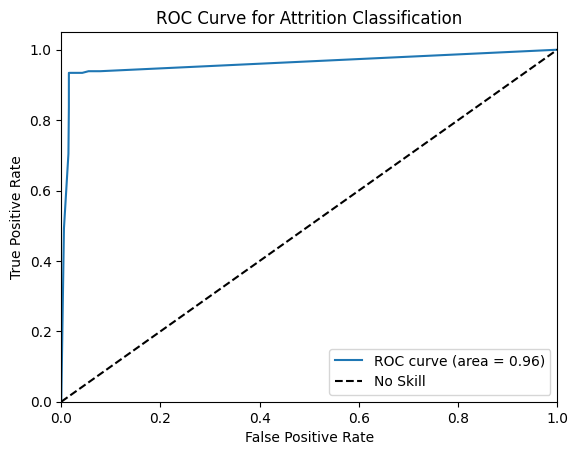

In [32]:
# ROC Curve

# Predict probabilities on the test set
target_pred_proba = knn.predict_proba(data_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(target_test, target_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

# Second model: Logistic regression


In [15]:
Logistic_reg = Pipeline([
        ('preprocessor', preprocessor),
        ('model', CalibratedClassifierCV(
            RandomizedSearchCV(
                LogisticRegression(max_iter=1000), param_distributions={'C': loguniform(1e-6, 1e6) },
                cv=cv, scoring=f1_scorer),
            method='isotonic',
            cv=4
        )
         )
    ])

In [16]:
cv_results = cross_validate(Logistic_reg, data_train, target_train, cv=skf, scoring=f1_scorer)
cv_results

{'fit_time': array([15.64995098, 13.38289785, 12.70238495, 15.27561283, 12.42881107,
        15.333992  , 15.94919562, 14.61918497, 16.0126431 , 12.54389572,
        14.40505219, 13.94151211, 14.65580392, 14.63854218, 15.15190983]),
 'score_time': array([0.01834297, 0.01900911, 0.01841307, 0.01737022, 0.0182209 ,
        0.01713777, 0.01914716, 0.01946211, 0.018152  , 0.01643705,
        0.01810169, 0.01689696, 0.02110577, 0.01780391, 0.01749301]),
 'test_score': array([0.42553191, 0.36363636, 0.41666667, 0.44      , 0.39130435,
        0.20408163, 0.27272727, 0.34782609, 0.26086957, 0.48979592,
        0.41509434, 0.375     , 0.48      , 0.40909091, 0.20512821])}

In [17]:
scores = cv_results["test_score"]
print(
    "The mean cross-validation f1 score is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation f1 score is: 0.366 ± 0.088


In [18]:
# Train the pipeline
Logistic_reg.fit(data_train, target_train)

# Predict on the testing set
target_predicted = Logistic_reg.predict(data_test)

# Evaluate the model
accuracy = accuracy_score(target_test, target_predicted)
print("Model Accuracy: ", accuracy)
print("Classification Report: \n", classification_report(target_test, target_predicted))
print("Confusion Matrix: \n", confusion_matrix(target_test, target_predicted))

Model Accuracy:  0.8594104308390023
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1110
           1       0.65      0.28      0.39       213

    accuracy                           0.86      1323
   macro avg       0.76      0.62      0.65      1323
weighted avg       0.84      0.86      0.83      1323

Confusion Matrix: 
 [[1078   32]
 [ 154   59]]


In [19]:
#print(f"The best set of parameters is: {Logistic_reg['model'].best_params_}")

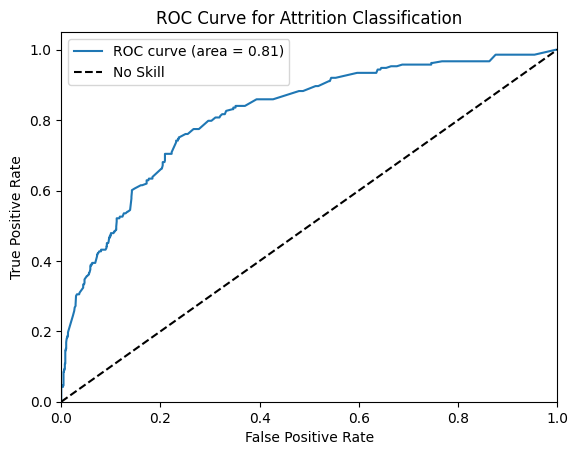

In [20]:
# ROC Curve

# Predict probabilities on the test set
target_pred_proba = Logistic_reg.predict_proba(data_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(target_test, target_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

# Third model: Decision Tree

In [21]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),  # Random integer values between 1 and 20
    'min_samples_split': randint(2, 20),  # Random integer values between 2 and 20
    'min_samples_leaf': randint(1, 20)  # Random integer values between 1 and 20
}

Tree = Pipeline([
        ('preprocessor', preprocessor),
        ('model', CalibratedClassifierCV(
            RandomizedSearchCV(
                DecisionTreeClassifier(random_state=0), param_distributions=param_distributions,
                cv=cv, scoring=f1_scorer),
            method='isotonic',
            cv=4
        )
         )
    ])



In [22]:
cv_results = cross_validate(Tree, data_train, target_train, cv=skf, scoring=f1_scorer)
cv_results

{'fit_time': array([9.37139702, 8.1216929 , 8.50587702, 8.04419303, 8.95390606,
        9.18378806, 9.13765693, 9.77060294, 8.68359184, 8.49462724,
        8.64224482, 8.79570293, 8.92245793, 8.76527834, 8.28049803]),
 'score_time': array([0.01828003, 0.01496029, 0.01486802, 0.02106714, 0.01578212,
        0.01752973, 0.01595998, 0.01546597, 0.01752329, 0.0151639 ,
        0.01606488, 0.0143609 , 0.015589  , 0.01511788, 0.01842189]),
 'test_score': array([0.56      , 0.66666667, 0.69230769, 0.8       , 0.70588235,
        0.82142857, 0.5       , 0.70588235, 0.70588235, 0.69230769,
        0.57692308, 0.53061224, 0.8       , 0.625     , 0.65306122])}

In [23]:
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.669 ± 0.094


In [24]:
# Train the pipeline
Tree.fit(data_train, target_train)

# Predict on the testing set
target_predicted = Tree.predict(data_test)

# Evaluate the model
accuracy = accuracy_score(target_test, target_predicted)
print("Model Accuracy: ", accuracy)
print("Classification Report: \n", classification_report(target_test, target_predicted))
print("Confusion Matrix: \n", confusion_matrix(target_test, target_predicted))

Model Accuracy:  0.9319727891156463
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1110
           1       0.96      0.60      0.74       213

    accuracy                           0.93      1323
   macro avg       0.95      0.80      0.85      1323
weighted avg       0.93      0.93      0.93      1323

Confusion Matrix: 
 [[1105    5]
 [  85  128]]


In [ ]:
#print(f"The best set of parameters is: {Tree['model'].best_params_}")

In [ ]:
# new_data = Tree['preprocessor'].fit_transform(data)
# col = [col_name for col_name in numerical_columns]
# col.extend(Tree['preprocessor'].transformers_[1][1]['encoder'].get_feature_names_out(
#     input_features=categorical_columns
# )
#                         )

# viz = dtreeviz.model(Tree['model'].best_estimator_, pd.DataFrame(new_data, index=data.index, columns=col), target,
#            target_name='Attrition',
#            feature_names=col, 
#            class_names=list(target.unique()))  

# # In a notebook, you can render inline without calling show()
# viz.view(scale=1.4) 
# # Uncomment to save with scale 1
# #vizRender = viz.view(scale=1)
# #vizRender.save("attrition_decision_tree.svg"

In [ ]:
# importances = Tree['model'].best_estimator_.feature_importances_
# feature_names = np.array(col) # Assuming feature names are like [0, 1, 2, ..., n_features-1]

# # Sort feature importances in descending order
# sorted_indices = np.argsort(importances)[::-1]
# sorted_importances = importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# # Plot feature importances using seaborn
# plt.figure(figsize=(15, 15))
# sns.barplot(x=sorted_importances, y=sorted_feature_names, palette='viridis')
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Decision Tree Classifier - Feature Importance')
# plt.show()

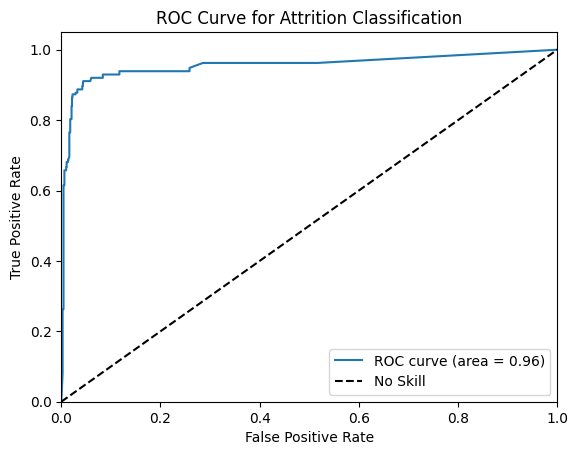

In [25]:
# ROC Curve

# Predict probabilities on the test set
target_pred_proba = Tree.predict_proba(data_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(target_test, target_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

# A more powerful model

In [26]:
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("encoder", OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
))
    ]
)

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_transformer, categorical_columns_selected),
        ("num", numerical_transformer, numerical_columns_selected),
    ]
)

param_distributions = {
    "l2_regularization": loguniform(1e-6, 1e3),
    "learning_rate": loguniform(0.001, 10),
    "max_leaf_nodes": loguniform_int(2, 256),
    "min_samples_leaf": loguniform_int(1, 100),
    "max_bins": loguniform_int(2, 255),
}


HistBoost = Pipeline([
        ('preprocessor', preprocessor),
        ('model', CalibratedClassifierCV(
            RandomizedSearchCV(
                HistGradientBoostingClassifier(random_state=42),
                param_distributions=param_distributions,
                cv=cv, scoring=f1_scorer),
            method='isotonic',
            cv=4
        )
         )
    ])

In [27]:
cv_results = cross_validate(HistBoost, data_train, target_train, cv=skf, scoring=f1_scorer)
cv_results

{'fit_time': array([221.16336465, 246.28721404, 141.62999296, 203.83920288,
        205.04872894, 214.90018892, 373.94380903, 289.96388078,
        235.88609195, 207.98631287, 176.50820303, 277.62224293,
        336.15859103, 300.69305491, 289.26565814]),
 'score_time': array([0.03089118, 0.02877498, 0.02739096, 0.03122211, 0.05747008,
        0.02972007, 0.03371978, 0.0282321 , 0.02783513, 0.03380799,
        0.02877212, 0.02976894, 0.03427887, 0.02912617, 0.03715992]),
 'test_score': array([0.92063492, 0.92063492, 0.93548387, 0.88135593, 0.95238095,
        0.93548387, 0.87096774, 0.91803279, 0.91803279, 0.95384615,
        0.875     , 0.92063492, 0.96875   , 0.95238095, 0.96969697])}

In [28]:
scores = cv_results["test_score"]
print(
    "The mean cross-validation f1 score is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation f1 score is: 0.926 ± 0.030


In [29]:
# Train the pipeline
HistBoost.fit(data_train, target_train)

# Predict on the testing set
target_predicted = HistBoost.predict(data_test)

# Evaluate the model
accuracy = accuracy_score(target_test, target_predicted)
print("Model Accuracy: ", accuracy)
print("Classification Report: \n", classification_report(target_test, target_predicted))
print("Confusion Matrix: \n", confusion_matrix(target_test, target_predicted))

Model Accuracy:  0.9841269841269841
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1110
           1       0.97      0.93      0.95       213

    accuracy                           0.98      1323
   macro avg       0.98      0.96      0.97      1323
weighted avg       0.98      0.98      0.98      1323

Confusion Matrix: 
 [[1104    6]
 [  15  198]]


In [ ]:
#print(f"The best set of parameters is: {HistBoost['model'].best_params_}")

In [ ]:
result = permutation_importance(HistBoost, data, target, n_repeats=10,random_state=3)
feature_names = np.array(numerical_columns+categorical_columns)

indices = np.argsort(result.importances_mean)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(indices)), result.importances_mean[indices],
       color="r", xerr=result.importances_std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(indices)), feature_names[indices])
plt.ylim([-1, len(indices)])
plt.show()

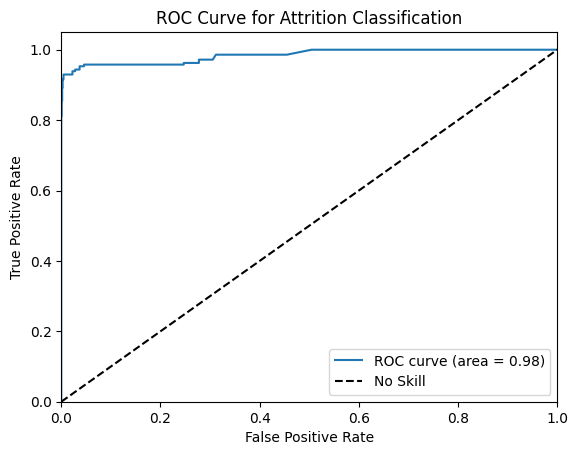

In [31]:
# ROC Curve

# Predict probabilities on the test set
target_pred_proba = HistBoost.predict_proba(data_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(target_test, target_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()